**Install Tensorflow**

In [ ]:
!pip install tensorflow

**Import Library**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.15.0
1.23.5
1.5.3


**Mount drive and link your folder**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'bismillah (AutoRecovered).gdoc'   gambar_1230.xml   gambar_165.jpg   gambar_275.xml
 capstone			   gambar_1231.xml   gambar_165.xml   gambar_276.xml
'Colab Notebooks'		   gambar_1232.xml   gambar_166.jpg   gambar_277.xml
 customTF			   gambar_1233.xml   gambar_166.xml   gambar_278.jpg
 customTF2			   gambar_1234.xml   gambar_167.jpg   gambar_278.xml
 data2.mp4			   gambar_1235.xml   gambar_167.xml   gambar_279.xml
 gambar_1038.xml		   gambar_1236.xml   gambar_169.jpg   gambar_280.xml
 gambar_1039.jpg		   gambar_1237.xml   gambar_169.xml   gambar_281.xml
 gambar_1039.xml		   gambar_1238.xml   gambar_170.jpg   gambar_282.xml
 gambar_1040.jpg		   gambar_1239.xml   gambar_170.xml   gambar_283.jpg
 gambar_1040.xml		   gambar_1240.xml   gambar_171.jpg   gambar_283.xml
 gambar_1041.xml		   gambar_1241.xml   gambar_171.xml   gambar_284.xml
 gambar_1042.jpg		   gambar_1242.xml   gambar_172.jpg   gambar_285.xml
 gambar_1042.xml		   gambar_1243.xml   gambar_172.xml   g

**Gather Data**

In [ ]:
train_data_dir = "/content/gdrive/MyDrive/capstone/train"
test_data_dir = "/content/gdrive/MyDrive/capstone/test"

BATCH_SIZE = 64
IMG_SIZE = (160, 160)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data #test data dir different from train data dir
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary',
    subset='validation') # set as validation data

train_generator.class_indices

Found 746 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


{'immature': 0, 'mature': 1, 'normal': 2}

**Image visualization of the dataset**

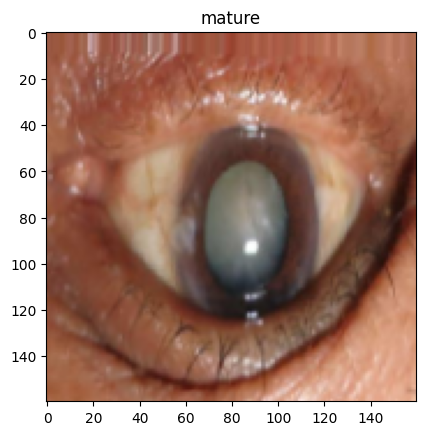

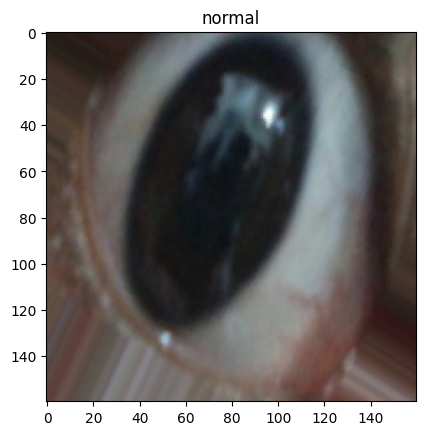

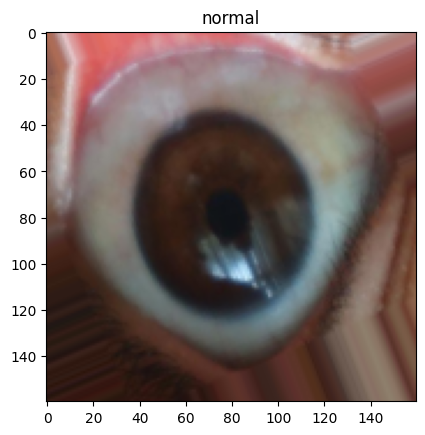

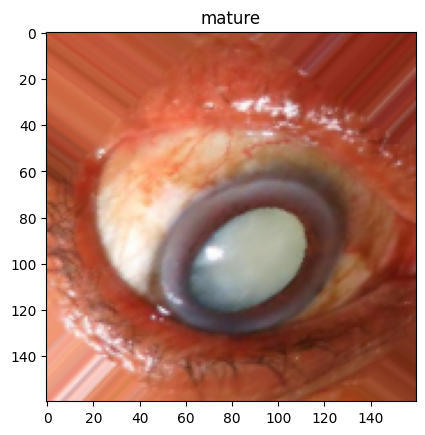

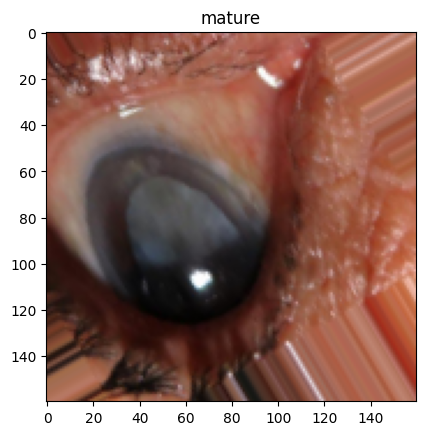

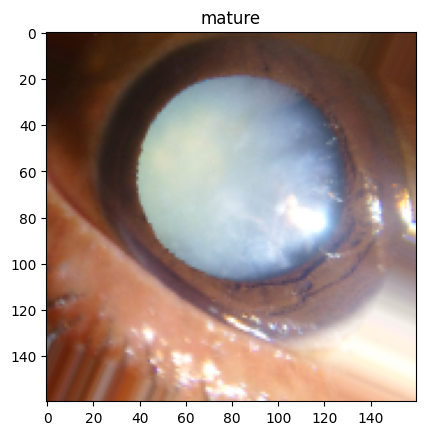

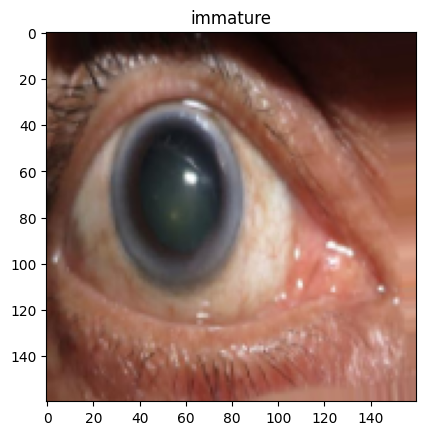

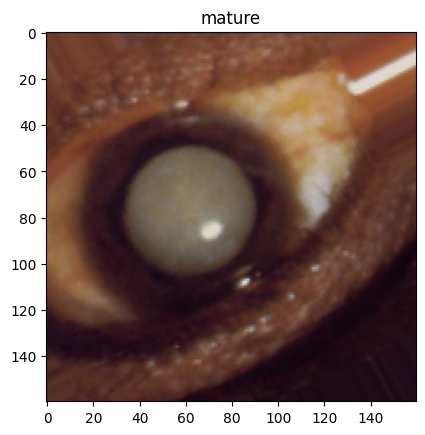

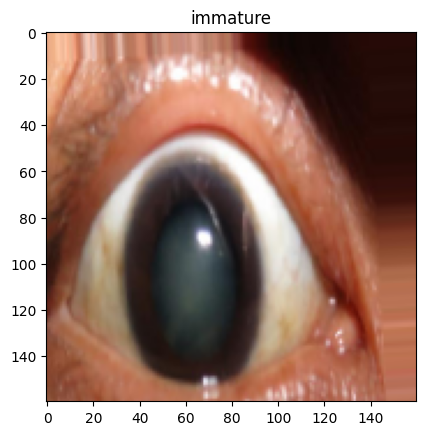

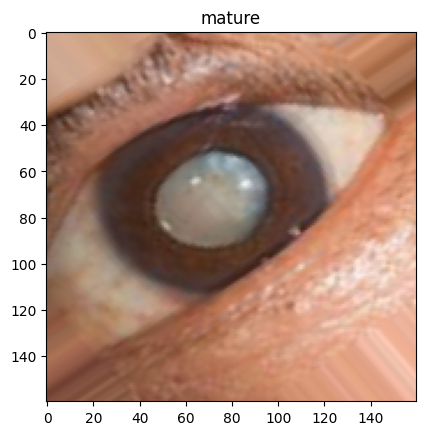

In [ ]:
class_names = ["immature", "mature", "normal"]

x,y = train_generator.next()
for i in range(0,10):
    image = x[i]
    label = y[i]
    plt.title(class_names[int(label)])
    plt.imshow(image)
    plt.show()


**Process Training**

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
# 64 gambar, karena batch_size kita adalah 64
print(feature_batch.shape)

(64, 5, 5, 1280)


In [ ]:
base_model.trainable = False
#base_model.trainable = True

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# (64, 5, 5, 1280) -> (64, 1280)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
#prediction_layer = tf.keras.layers.Dense(6)
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(inputs, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_generator)

1/1 [==============================] - 4s 4s/step - loss: 1.5509 - accuracy: 0.2174


In [ ]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)

Epoch 1/20
12/12 [==============================] - 118s 9s/step - loss: 1.3900 - accuracy: 0.3901 - val_loss: 1.1907 - val_accuracy: 0.3261
Epoch 2/20
12/12 [==============================] - 30s 2s/step - loss: 1.1744 - accuracy: 0.4209 - val_loss: 1.2616 - val_accuracy: 0.3913
Epoch 3/20
12/12 [==============================] - 26s 2s/step - loss: 1.1321 - accuracy: 0.4759 - val_loss: 1.2040 - val_accuracy: 0.2826
Epoch 4/20
12/12 [==============================] - 29s 2s/step - loss: 1.0626 - accuracy: 0.4839 - val_loss: 1.0669 - val_accuracy: 0.5435
Epoch 5/20
12/12 [==============================] - 30s 2s/step - loss: 1.0058 - accuracy: 0.5496 - val_loss: 1.0287 - val_accuracy: 0.5217
Epoch 6/20
12/12 [==============================] - 30s 2s/step - loss: 0.9347 - accuracy: 0.5804 - val_loss: 1.0270 - val_accuracy: 0.5000
Epoch 7/20
12/12 [==============================] - 27s 2s/step - loss: 0.9201 - accuracy: 0.5898 - val_loss: 1.1329 - val_accuracy: 0.4565
Epoch 8/20
12/12 [=

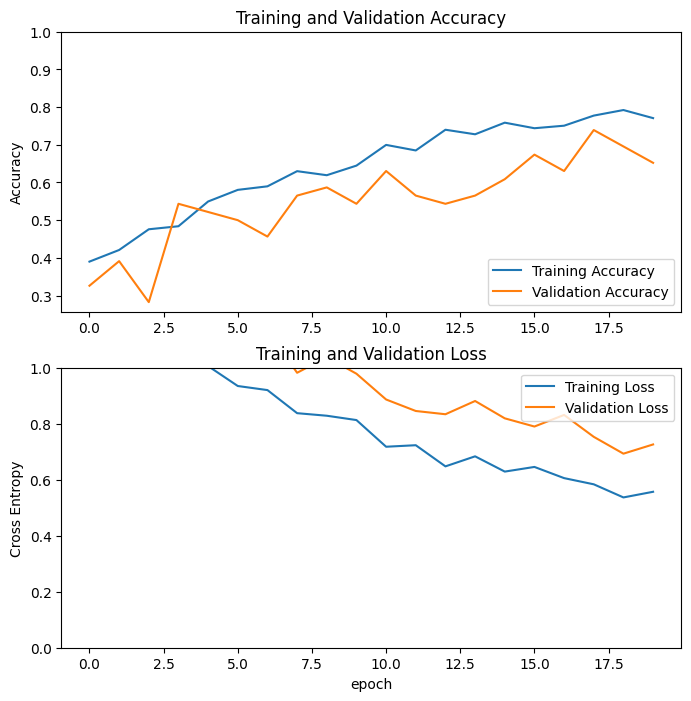

In [ ]:
# model.save('/')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
#fine_tune_at = 100
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 2178435 (8.

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         batch_size=12,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 20/40
12/12 [==============================] - 51s 3s/step - loss: 0.4283 - accuracy: 0.8472 - val_loss: 0.4866 - val_accuracy: 0.8043
Epoch 21/40
12/12 [==============================] - 45s 4s/step - loss: 0.2400 - accuracy: 0.9196 - val_loss: 0.2813 - val_accuracy: 0.9565
Epoch 22/40
12/12 [==============================] - 39s 3s/step - loss: 0.1905 - accuracy: 0.9357 - val_loss: 0.3440 - val_accuracy: 0.8478
Epoch 23/40
12/12 [==============================] - 37s 3s/step - loss: 0.1272 - accuracy: 0.9611 - val_loss: 0.1715 - val_accuracy: 0.9783
Epoch 24/40
12/12 [==============================] - 41s 3s/step - loss: 0.1176 - accuracy: 0.9544 - val_loss: 0.3933 - val_accuracy: 0.7826
Epoch 25/40
12/12 [==============================] - 40s 3s/step - loss: 0.0948 - accuracy: 0.9718 - val_loss: 0.1768 - val_accuracy: 0.9130
Epoch 26/40
12/12 [==============================] - 37s 3s/step - loss: 0.1007 - accuracy: 0.9705 - val_loss: 0.2406 - val_accuracy: 0.8913
Epoch 27/40
1

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

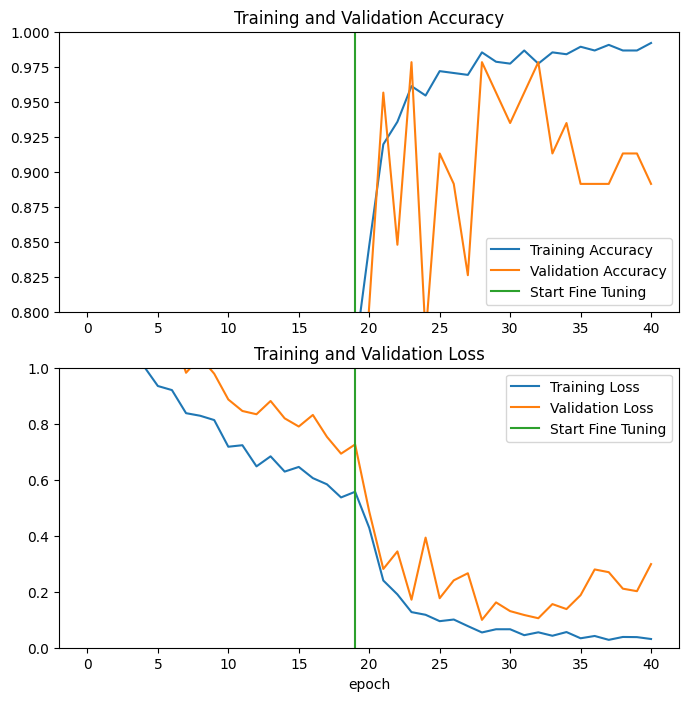

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [ ]:
test_data_dir = "/content/gdrive/MyDrive/capstone/test"

BATCH_SIZE = 64
IMG_SIZE = (160, 160)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)

print('Test accuracy:', accuracy)

Found 235 images belonging to 3 classes.
4/4 [==============================] - 39s 13s/step - loss: 0.1012 - accuracy: 0.9532
Test accuracy: 0.9531915187835693


In [ ]:
predictions = model.predict(test_generator)
predictions[0]

4/4 [==============================] - 8s 2s/step


array([-7.054079  ,  7.544378  , -0.50268817], dtype=float32)

**Testing Training**

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

path = "/content/gdrive/MyDrive/capstone/test/normal/00000023.jpg"
# path = validation_generator[0]
img = load_img(path, target_size=(160, 160))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = probability_model.predict(images, batch_size=64)
print(path)
print(classes)
i = np.argmax(classes[0])
print(class_names[i])



1/1 [==============================] - 0s 72ms/step
/content/gdrive/MyDrive/capstone/test/normal/00000023.jpg
[[0.00487569 0.2641315  0.7309928 ]]
normal


In [ ]:
y_pred_raw = probability_model.predict(test_generator)
y_pred = np.argmax(y_pred_raw,axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)


4/4 [==============================] - 6s 929ms/step


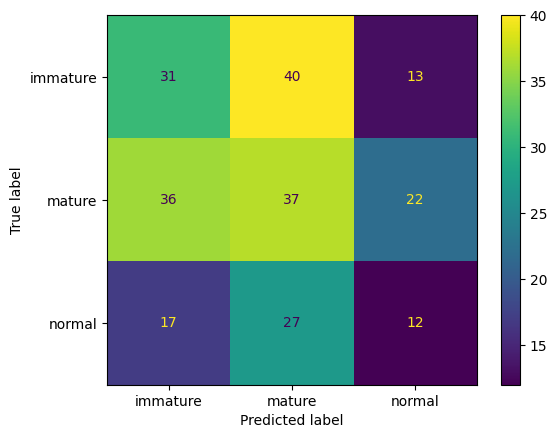

0.3404255319148936
[0.36904762 0.35576923 0.25531915]
[0.36904762 0.38947368 0.21428571]
[0.36904762 0.3718593  0.23300971]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["immature","mature","normal"])
cm_display.plot()
plt.show()

accuracyNew = accuracy_score(test_generator.classes, y_pred)
precisionNew = precision_score(test_generator.classes, y_pred, average=None)
recallNew = recall_score(test_generator.classes, y_pred, average=None)
f1New = f1_score(test_generator.classes, y_pred, average=None)
print(accuracyNew)
print(precisionNew)
print(recallNew)
print(f1New)

**Save Model**

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/gdrive/MyDrive/hasil/model_result.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/hasil/model_inceptionx.h5')